In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import matplotlib
import numpy as np
import pylab as pl
import sys
import sklearn
import sklearn.datasets
import sklearn.linear_model
#import matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
primary_results = pd.read_csv( 'primary_results.csv' )
county_facts = pd.read_csv( 'county_facts.csv' )
county_facts_dict = pd.read_csv( 'county_facts_dictionary.csv' )
primary_results.head(2)

,state,state_abbreviation,county,fips,party,candidate,votes,fraction_votes
0,Alabama,AL,Autauga,1001,Republican,Donald Trump,5387,0.445
1,Alabama,AL,Autauga,1001,Republican,Ted Cruz,2482,0.205


In [3]:
#delete variables that we don't want in below loop 
primary_results.index = primary_results['fips']
del primary_results['fips']

county_facts.index = county_facts['fips']
del county_facts['fips']

#set the variable code as the index of the dataframe
county_facts_dict.index = county_facts_dict['column_name']
del county_facts_dict['column_name']

In [4]:
#this pulls out the unique county ids from primary results and then picks up 
#the country facts about them and throws them into county fact results
#PST045214	Population, 2014 estimate
#POP815213   Language other than English spoken at home, pct age 5+, 2009-2013
#VET605213	Veterans, 2009-2013
#SBO015207	Women-owned firms, percent, 2007
#HSG495213	Median value of owner-occupied housing units, 2009-2013
county_facts_results = county_facts.loc[sorted(list(set(primary_results.index))), : ]

In [35]:
#bring in county characteristics
primary_results.loc[:, 'percent_high_school'] = county_facts_results.loc[:, 'EDU635213' ]
primary_results.loc[:, 'percent_bachelors'] = county_facts_results.loc[:, 'EDU685213' ]
primary_results.loc[:, 'percent_notenglish'] = county_facts_results.loc[:, 'POP815213' ]
primary_results.loc[:, 'veterans'] = county_facts_results.loc[:, 'VET605213' ]
primary_results.loc[:, 'population'] = county_facts_results.loc[:, 'PST045214' ]
primary_results.loc[:, 'percent_vets'] = primary_results.loc[:, 'veterans']/primary_results.loc[:, 'population']
primary_results.loc[:, 'percent_fbiz'] = county_facts_results.loc[:, 'SBO015207' ]
primary_results.loc[:, 'housing_value'] = county_facts_results.loc[:, 'HSG495213' ]
primary_results.loc[:, 'over65'] = county_facts_results.loc[:, 'AGE775214' ]
primary_results.loc[:, 'ownshome'] = county_facts_results.loc[:, 'HSG445213' ]
primary_results.loc[:, 'black_biz'] = county_facts_results.loc[:, 'SBO315207' ]



In [67]:
primary_results.head(2)

,state,state_abbreviation,county,party,candidate,votes,fraction_votes,percent_high_school,percent_bachelors,percent_notenglish,...,population,percent_vets,percent_fbiz,housing_value,over65,ownshome,black_biz,max_votesR,max_votesD,classifier
5,Alabama,AL,Autauga,Democrat,Hillary Clinton,2387,0.800,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.445,0.800,1.0
12,Alabama,AL,Baldwin,Democrat,Hillary Clinton,5290,0.647,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.469,0.794,0.0


In [110]:
#Create classify. 1 if percent votes equals max percent votes in country by party
#Group by party and candidate
primary_resultsR = primary_results[primary_results['party'] == "Republican"]
primary_resultsD = primary_results[primary_results['party'] == "Democrat"]

#Explain collapsing and grouping
#Get max vote by county
party_candidateR = primary_resultsR['fraction_votes'].groupby(primary_resultsR['county']).max()
party_candidateD = primary_resultsD['fraction_votes'].groupby(primary_resultsD['county'],as_index = True).max()

#Create total votes by county
#total_votes = primary_results['votes'].groupby(primary_results['state', 'county']).sum()

all_votes = primary_results.loc[:,['votes', 'state', 'county', 'party']]
party_votes = all_votes.groupby(['state', 'county', 'party'], as_index=False)['votes'].sum()
total_votes = all_votes.groupby(['state', 'county'], as_index=False)['votes'].sum()
frac_party_votes = pd.merge(total_votes, party_votes, on = ['state', 'county'], how='outer')
#party_votes.columns
frac_party_votes.columns
total_votes.head(2)


,state,county,votes
0,Alabama,Autauga,2387
1,Alabama,Baldwin,5290


In [89]:
#make sure both are data frames
party_candidateR = pd.DataFrame(party_candidateR)
party_candidateD = pd.DataFrame(party_candidateD)
primary_results = pd.DataFrame(primary_results)

In [9]:
#relabel fraction_votes
#no great way to relabel
party_candidateR.rename(columns={'fraction_votes':'max_votesR'}, inplace=True)
party_candidateR['county'] = party_candidateR.index

party_candidateD.rename(columns={'fraction_votes':'max_votesD'}, inplace=True)
party_candidateD['county'] = party_candidateD.index

In [10]:
#Get the maximums back into primary_results
#explain joins and merges and "in place"
primary_results = pd.merge(primary_results, party_candidateR, on='county', how='outer')


In [11]:
primary_results = pd.merge(primary_results, party_candidateD, on='county', how='outer')

In [12]:
#creteate a dummy variable a long way
primary_results.ix[primary_results['fraction_votes'] == primary_results['max_votesR'], 'classifier'] = 1
primary_results.ix[primary_results['fraction_votes'] == primary_results['max_votesD'], 'classifier'] = 1
#primary_results.ix[primary_results['classifier'] == 'NaN', 'classifier'] = 0

primary_results['classifier'].fillna(0)
primary_results.fillna(0)


,state,state_abbreviation,county,party,candidate,votes,fraction_votes,percent_high_school,percent_bachelors,percent_notenglish,...,population,percent_vets,percent_fbiz,housing_value,over65,ownshome,black_biz,max_votesR,max_votesD,classifier
0,Alabama,AL,Autauga,Republican,Donald Trump,5387,0.445000,85.6,20.9,3.5,...,55395,0.106905,31.7,136200,13.8,76.8,15.2,0.445000,0.800000,1.0
1,Alabama,AL,Autauga,Republican,Ted Cruz,2482,0.205000,85.6,20.9,3.5,...,55395,0.106905,31.7,136200,13.8,76.8,15.2,0.445000,0.800000,0.0
2,Alabama,AL,Autauga,Republican,Marco Rubio,1785,0.148000,85.6,20.9,3.5,...,55395,0.106905,31.7,136200,13.8,76.8,15.2,0.445000,0.800000,0.0
3,Alabama,AL,Autauga,Republican,Ben Carson,1764,0.146000,85.6,20.9,3.5,...,55395,0.106905,31.7,136200,13.8,76.8,15.2,0.445000,0.800000,0.0
4,Alabama,AL,Autauga,Republican,John Kasich,421,0.035000,85.6,20.9,3.5,...,55395,0.106905,31.7,136200,13.8,76.8,15.2,0.445000,0.800000,0.0
5,Alabama,AL,Autauga,Democrat,Hillary Clinton,2387,0.800000,85.6,20.9,3.5,...,55395,0.106905,31.7,136200,13.8,76.8,15.2,0.445000,0.800000,1.0
6,Alabama,AL,Autauga,Democrat,Bernie Sanders,544,0.182000,85.6,20.9,3.5,...,55395,0.106905,31.7,136200,13.8,76.8,15.2,0.445000,0.800000,0.0
7,Alabama,AL,Baldwin,Republican,Donald Trump,23618,0.469000,89.1,27.7,5.5,...,200111,0.096676,27.3,168600,18.7,72.6,2.7,0.469000,0.794000,1.0
8,Alabama,AL,Baldwin,Republican,Marco Rubio,9703,0.193000,89.1,27.7,5.5,...,200111,0.096676,27.3,168600,18.7,72.6,2.7,0.469000,0.794000,0.0
9,Alabama,AL,Baldwin,Republican,Ted Cruz,8571,0.170000,89.1,27.7,5.5,...,200111,0.096676,27.3,168600,18.7,72.6,2.7,0.469000,0.794000,0.0


In [13]:
#Was hoping this would work a la R
#primary_results['classifer'] = primary_results[ (primary_results['fraction_votes'] == primary_results['max_votesR']) 
# | (primary_results['fraction_votes'] == primary_results['max_votesD'])]
#    s[(s < -1) | (s > 1 )]

In [14]:
primary_results.head(2)

,state,state_abbreviation,county,party,candidate,votes,fraction_votes,percent_high_school,percent_bachelors,percent_notenglish,...,population,percent_vets,percent_fbiz,housing_value,over65,ownshome,black_biz,max_votesR,max_votesD,classifier
0,Alabama,AL,Autauga,Republican,Donald Trump,5387,0.445,85.6,20.9,3.5,...,55395,0.106905,31.7,136200,13.8,76.8,15.2,0.445,0.8,1.0
1,Alabama,AL,Autauga,Republican,Ted Cruz,2482,0.205,85.6,20.9,3.5,...,55395,0.106905,31.7,136200,13.8,76.8,15.2,0.445,0.8,NaN


In [15]:
#it does not replace it, so we need to brute force do this
primary_results['classifier'] = primary_results['classifier'].fillna(0)
primary_results.head(2)

,state,state_abbreviation,county,party,candidate,votes,fraction_votes,percent_high_school,percent_bachelors,percent_notenglish,...,population,percent_vets,percent_fbiz,housing_value,over65,ownshome,black_biz,max_votesR,max_votesD,classifier
0,Alabama,AL,Autauga,Republican,Donald Trump,5387,0.445,85.6,20.9,3.5,...,55395,0.106905,31.7,136200,13.8,76.8,15.2,0.445,0.8,1.0
1,Alabama,AL,Autauga,Republican,Ted Cruz,2482,0.205,85.6,20.9,3.5,...,55395,0.106905,31.7,136200,13.8,76.8,15.2,0.445,0.8,0.0


In [16]:
primary_results.head(5)
primary_results.to_csv('primary_results_test', sep='\t')

In [17]:
#now we're ready for ML, convert stuff to numpy arrays
#df.loc[df['c']>0.5,['a','d']].values
#put classifer into y numpary array
#put percent_fbiz and percent_vets into X numpy array

In [18]:
#Predict Hillary winning the primary based on fraction of elderly and not English speakers
primary_results = primary_results[primary_results['candidate'] == "Hillary Clinton"]
primary_results.head(10)

,state,state_abbreviation,county,party,candidate,votes,fraction_votes,percent_high_school,percent_bachelors,percent_notenglish,...,population,percent_vets,percent_fbiz,housing_value,over65,ownshome,black_biz,max_votesR,max_votesD,classifier
5,Alabama,AL,Autauga,Democrat,Hillary Clinton,2387,0.800,85.6,20.9,3.5,...,55395,0.106905,31.7,136200,13.8,76.8,15.2,0.445,0.800,1.0
12,Alabama,AL,Baldwin,Democrat,Hillary Clinton,5290,0.647,89.1,27.7,5.5,...,200111,0.096676,27.3,168600,18.7,72.6,2.7,0.469,0.794,0.0
19,Georgia,GA,Baldwin,Democrat,Hillary Clinton,3034,0.794,81.7,19.0,3.7,...,45909,0.067067,26.6,103900,14.2,57.2,0.0,0.469,0.794,1.0
26,Alabama,AL,Barbour,Democrat,Hillary Clinton,2567,0.906,73.7,13.4,5.0,...,26887,0.078849,27.0,89200,16.5,67.7,0.0,0.501,0.906,1.0
33,Alabama,AL,Bibb,Democrat,Hillary Clinton,942,0.755,77.5,12.1,2.1,...,22506,0.058962,0.0,90500,14.8,79.0,14.9,0.494,0.828,0.0
40,Georgia,GA,Bibb,Democrat,Hillary Clinton,12944,0.828,82.4,22.5,5.1,...,153905,0.074708,35.1,123000,14.0,54.4,32.5,0.494,0.828,1.0
47,Alabama,AL,Blount,Democrat,Hillary Clinton,564,0.551,77.0,12.1,7.3,...,57719,0.078657,23.2,117100,17.0,81.0,0.0,0.487,0.551,1.0
54,Tennessee,TN,Blount,Democrat,Hillary Clinton,2736,0.531,86.7,20.8,3.9,...,126339,0.092790,25.7,163900,18.4,73.3,0.0,0.487,0.551,0.0
61,Alabama,AL,Bullock,Democrat,Hillary Clinton,2451,0.913,67.8,12.5,5.2,...,10764,0.059086,38.8,70600,14.9,74.3,0.0,0.565,0.913,1.0
68,Alabama,AL,Butler,Democrat,Hillary Clinton,2196,0.921,76.3,14.0,1.7,...,20296,0.073758,0.0,74700,18.0,70.3,0.0,0.538,0.921,1.0


In [19]:
primary_results.loc[:, ['over65', 'percent_notenglish']].head(2)

,over65,percent_notenglish
5,13.8,3.5
12,18.7,5.5


In [20]:
X = primary_results.loc[:, ['over65', 'percent_notenglish']].values
y = primary_results['classifier'].values
len(X)
len(y)

1928

In [21]:
X[1:10,:]

array([[ 18.7,   5.5],
       [ 14.2,   3.7],
       [ 16.5,   5. ],
       [ 14.8,   2.1],
       [ 14. ,   5.1],
       [ 17. ,   7.3],
       [ 18.4,   3.9],
       [ 14.9,   5.2],
       [ 18. ,   1.7]])

In [22]:
#X = X[1000:5000,:]
#y = y[1000:5000]
X_norm = (X - X.mean())/X.std()
y_norm = (y - y.mean())/y.std()
X_norm.std()
X_norm.mean()
X = X_norm
y = y_norm


In [23]:
#y is a float. it needs to be an integer for plt scatter and scikit
y = y.astype(int)
type(y)
len(y)

1928

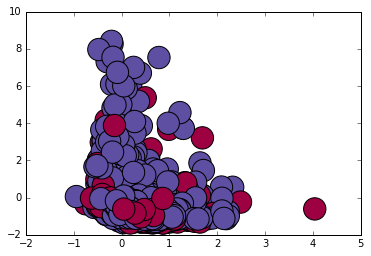

In [24]:
plt.scatter(X[:,0], X[:,1],s=500, c=y[:],cmap=plt.cm.Spectral)

In [25]:
# Train the logistic rgeression classifier
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X[1:500], y[1:500])

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [111]:
clf.coef_ 

array([[-0.00026039,  0.00063282]])

In [27]:
#unabashed stealing http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/

# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

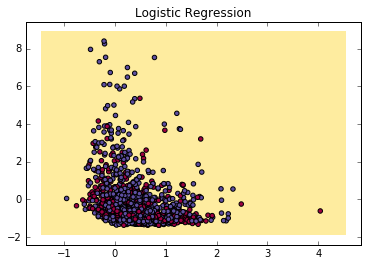

In [28]:
# Plot the decision boundary
# There is none
plot_decision_boundary(clf.predict)
plt.title("Logistic Regression")

In [29]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

In [30]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

In [31]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

In [193]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

Loss after iteration 0: 1.364725
Loss after iteration 1000: 6.352138
Loss after iteration 2000: 6.699906
Loss after iteration 3000: 6.783811
Loss after iteration 4000: 6.772227
Loss after iteration 5000: 6.749438
Loss after iteration 6000: 6.727026
Loss after iteration 7000: 6.704449
Loss after iteration 8000: 6.680426
Loss after iteration 9000: 6.660785
Loss after iteration 10000: 6.660582
Loss after iteration 11000: 6.665103
Loss after iteration 12000: 6.668847
Loss after iteration 13000: 6.671875
Loss after iteration 14000: 6.674336
Loss after iteration 15000: 6.676343
Loss after iteration 16000: 6.677985
Loss after iteration 17000: 6.679332
Loss after iteration 18000: 6.680439
Loss after iteration 19000: 6.681351


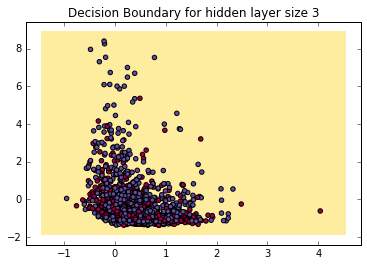

In [194]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")